**This notebook calculates the extreme runoff as the predictand, which embodied by runoff anomalies. Also, sets different extreme level by different stds extended, 0.5, 1, 1.5, 2.<br/>**

*By Jialu Wang*

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob


from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

**Runoff Data Import**

In [2]:
ro = xr.open_dataset('ERA5-LAND.nc').ro
ro

getfattr: /home/jovyan/EAEE4000_ML_EnvEng/Tutorials/Final: No such file or directory
getfattr: Project_Runoff: No such file or directory
getfattr: Extremes/ERA5-LAND.nc: No such file or directory


<xarray.DataArray 'ro' (valid_time: 360, latitude: 1801, longitude: 3600)> Size: 9GB
[2334096000 values with dtype=float32]
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 1995-01-01 ... 2024-12-01
  * latitude    (latitude) float64 14kB 90.0 89.9 89.8 ... -89.8 -89.9 -90.0
  * longitude   (longitude) float64 29kB 0.0 0.1 0.2 0.3 ... 359.7 359.8 359.9
    number      int64 8B ...
    expver      (valid_time) <U4 6kB ...
Attributes: (12/31)
    GRIB_paramId:                             205
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      6483600
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_gridType:                            regular_ll
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m
    long_name:                                Runoff
    units:                                    m
    standard_name:                            unknown
    GRIB_surface:                             0.0

**Calculate Runoff Anomalies: Deseasonalization & Normalization**

In [6]:
# downscalling
ds_ro = ro.coarsen(latitude=2, longitude=2, boundary='trim').mean()
# monthly
monthly_means = ds_ro.groupby('valid_time.month').mean(dim='valid_time')
monthly_stds = ds_ro.groupby('valid_time.month').std(dim='valid_time')
months = ds_ro.valid_time.dt.month
# means & std
means_expanded = monthly_means.sel(month=months)
stds_expanded = monthly_stds.sel(month=months)
"""
anomalies
-deseasonalization: data - monthly_clim
-normalization: deseasonalized/monthly_std
"""
ro_ano = (ds_ro - means_expanded) / stds_expanded
print(f"ds_ro_shape: {ro_ano.shape}")
print("Complete!")

/srv/conda/envs/notebook/lib/python3.12/site-packages/numbagg/decorators.py:245: RuntimeWarning: invalid value encountered in nanmean
  return self.gufunc(target=self.target)(*arrays, axis=-1)


ds_ro_shape: (360, 900, 1800)
Complete!


In [ ]:
# downscalling
ds_ro = ro.coarsen(latitude=2, longitude=2, boundary='trim').mean()
# monthly
monthly_means = ds_ro.groupby('valid_time.month').mean(dim='valid_time')
monthly_stds = ds_ro.groupby('valid_time.month').std(dim='valid_time')
months = ds_ro.valid_time.dt.month
# means & std
means_expanded = monthly_means.sel(month=months)
stds_expanded = monthly_stds.sel(month=months)
"""
anomalies
-deseasonalization: data - monthly_clim
-normalization: deseasonalized/monthly_std
"""
ro_ano = (ds_ro - means_expanded) / stds_expanded
print(f"ds_ro_shape: {ro_ano.shape}")
print("Complete!")

**Save Runoff Anomalies**

In [7]:
ro_ano.to_netcdf('runoff_anomalies.nc')

**Import Runoff Anomalies**

In [2]:
roa = xr.open_dataset('runoff_anomalies.nc')
roa

NameError: name 'xr' is not defined

In [12]:
time=roa.valid_time
lon=roa.longitude
lat=roa.latitude
x,y=np.meshgrid(lon,lat)

**Runoff Anomalies Trend Distribution**

In [1]:
from scipy.stats.mstats import ttest_ind
from scipy.stats import pearsonr
from scipy.stats import linregress

In [ ]:
roa_trend,r,p=np.zeros((900,1800)),np.zeros((900,1800)),np.zeros((900,1800))
for i in range(len(lat)):
    for j in range(len(lon)):
        roa_trend[i,j],_,r[i,j], p[i,j],_  = linregress(time,roa[:,i,j])
roa_trend=xr.DataArray(roa_trend,dims=['lat','lon'],coords=[lat,lon])

/srv/conda/envs/notebook/lib/python3.12/site-packages/numbagg/decorators.py:245: RuntimeWarning: invalid value encountered in nanmean
  return self.gufunc(target=self.target)(*arrays, axis=-1)


<xarray.DataArray 'ro' (latitude: 900, longitude: 1800)> Size: 6MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(900, 1800), dtype=float32)
Coordinates:
  * latitude   (latitude) float64 7kB 89.95 89.75 89.55 ... -89.45 -89.65 -89.85
  * longitude  (longitude) float64 14kB 0.05 0.25 0.45 ... 359.5 359.7 359.9
    number     int64 8B ...

Text(0.5, 1.0, 'Mean Runoff Anomalies(p=0.2)')

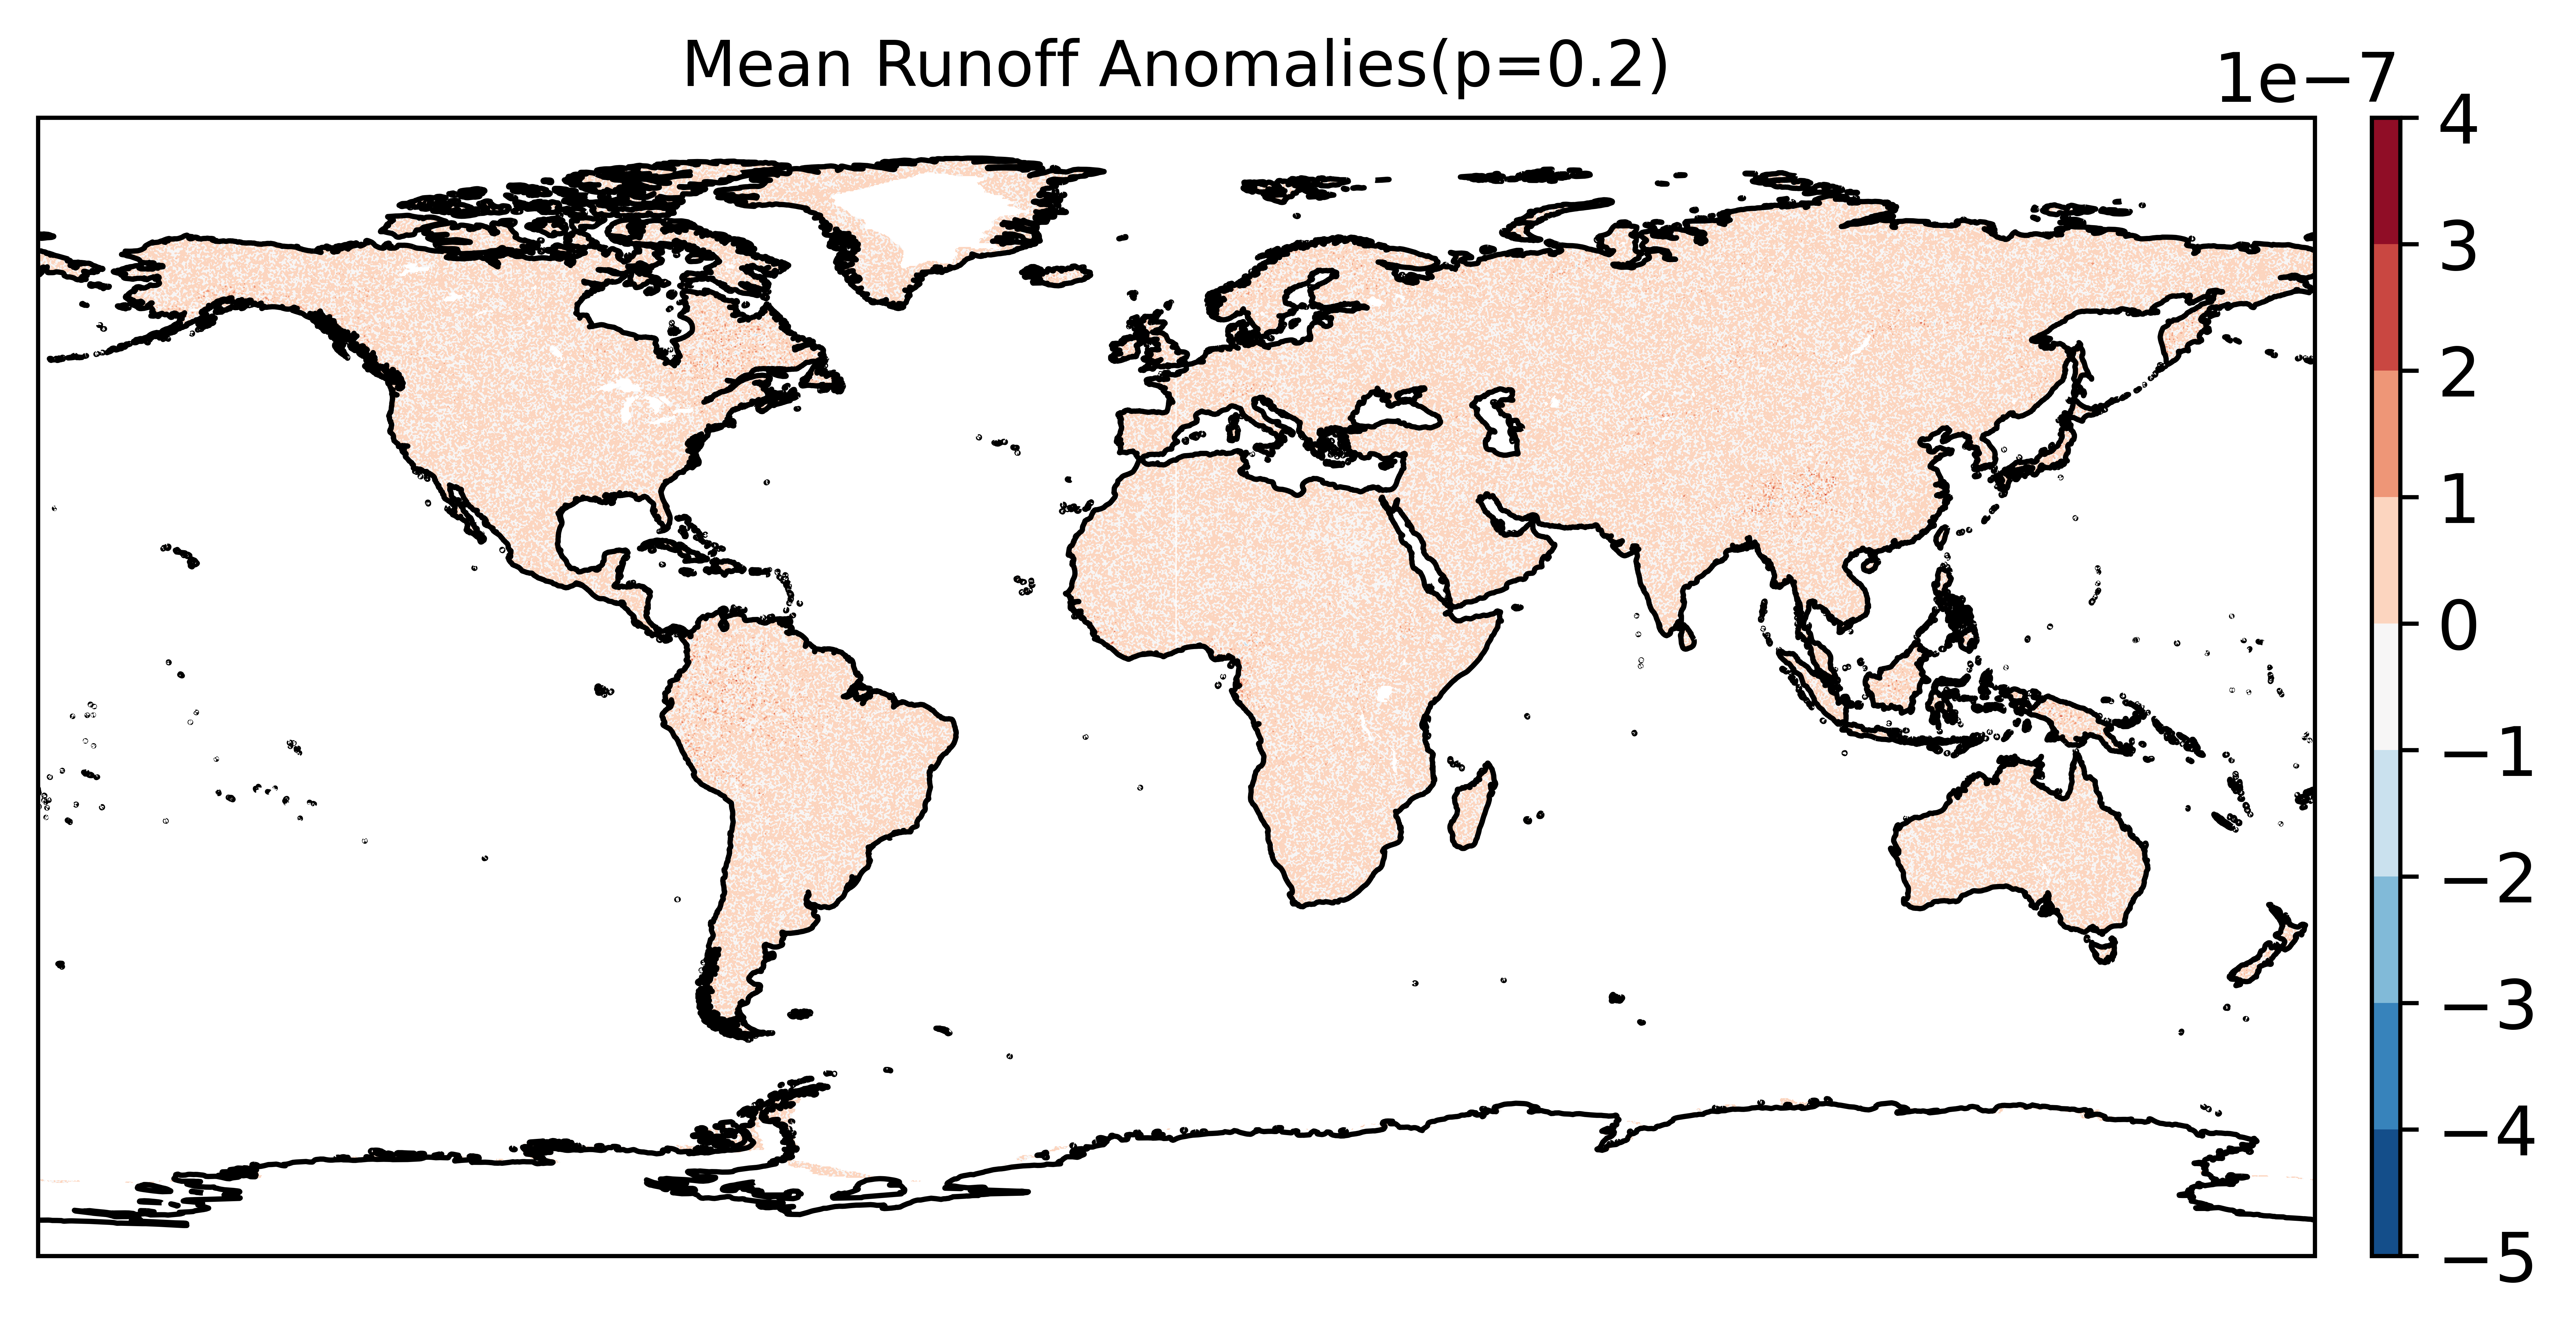

In [20]:
fig=plt.figure(figsize=(15,15),dpi=600)
ax = fig.add_axes([0.05,0.75,0.4,0.3],projection = ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m')) 
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
roa_ave=ax.contourf(x,y,roa_ave,cmap='RdBu_r',transform=ccrs.PlateCarree())#,levels=np.arange(-0.2,0.2,0.005))
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.005,ax.get_position().height])
plt.colorbar(roa_ave, cax=cax) 
ax.set_title('Mean Runoff Anomalies',fontsize=12)
#fig.savefig(r'D:\Data\CHDE\1979-2022 Eastern_China_CHDE_Trend(p=0.2).png',dpi=600,format='png',bbox_inches='tight',pad_inches=0.1)

**Predictors Data Import**

In [2]:
ds = xr.open_dataset('ERA5-LAND.nc')
ds

getfattr: /home/jovyan/EAEE4000_ML_EnvEng/Tutorials/Final: No such file or directory
getfattr: Project_Runoff: No such file or directory
getfattr: Extremes/ERA5-LAND.nc: No such file or directory


<xarray.Dataset> Size: 37GB
Dimensions:     (valid_time: 360, latitude: 1801, longitude: 3600)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 1995-01-01 ... 2024-12-01
  * latitude    (latitude) float64 14kB 90.0 89.9 89.8 ... -89.8 -89.9 -90.0
  * longitude   (longitude) float64 29kB 0.0 0.1 0.2 0.3 ... 359.7 359.8 359.9
    number      int64 8B ...
    expver      (valid_time) <U4 6kB ...
Data variables:
    swvl1       (valid_time, latitude, longitude) float32 9GB ...
    evaow       (valid_time, latitude, longitude) float32 9GB ...
    ro          (valid_time, latitude, longitude) float32 9GB ...
    tp          (valid_time, latitude, longitude) float32 9GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-20T04:50 GRIB to CDM+CF via cfgrib-0.9.1...

**Calculate annually predictors<br/>**

*1-totoal precipitation (tp) : sum<br/>*
*2-evaporation (evaow) : sum<br/>*
*3-surface soil moisture (swvl1): mean<br/>*


****tp-sum****

In [4]:
# downscalling
ds_tp = ds.tp.coarsen(latitude=2, longitude=2, boundary='trim').mean()
tp_yearly=ds_tp.groupby('valid_time.year').sum('valid_time')
tp_yearly

/srv/conda/envs/notebook/lib/python3.12/site-packages/numbagg/decorators.py:245: RuntimeWarning: invalid value encountered in nanmean
  return self.gufunc(target=self.target)(*arrays, axis=-1)


<xarray.DataArray 'tp' (year: 30, latitude: 900, longitude: 1800)> Size: 194MB
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.00219928, 0.00219886, 0.00219843, ..., 0.00219973,
         0.00219959, 0.00219947],
        [0.00216575, 0.00216527, 0.0021648 , ..., 0.00216657,
         0.00216632, 0.00216605],
        [0.00212573, 0.00212536, 0.00212499, ..., 0.00212668,
         0.00212635, 0.00212605]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [0.00140927, 0.00140916, 0.00140905, ..., 0.00140943,
         0.00140938, 0.00140933],
        [0.00141238, 0.00141231, 0.00141223, ..., 0.00141266,
         0.00141257, 0.00141247],
        [0.00140376, 0.00140356, 0.00140336, ..., 0.00140434,
         0.00140415, 0.00140396]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.00236859, 0.00236862, 0.00236864, ..., 0.00236801,
         0.00236822, 0.00236842],
        [0.0023921 , 0.00239213, 0.00239215, ..., 0.00239208,
         0.00239208, 0.00239209],
        [0.0023867 , 0.00238644, 0.00238617, ..., 0.00238753,
         0.00238726, 0.00238697]]], shape=(30, 900, 1800), dtype=float32)
Coordinates:
  * year       (year) int64 240B 1995 1996 1997 1998 ... 2021 2022 2023 2024
  * latitude   (latitude) float64 7kB 89.95 89.75 89.55 ... -89.45 -89.65 -89.85
  * longitude  (longitude) float64 14kB 0.05 0.25 0.45 ... 359.5 359.7 359.9
    number     int64 8B ...
Attributes: (12/31)
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      6483600
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_gridType:                            regular_ll
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m
    long_name:                                Total precipitation
    units:                                    m
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [5]:
tp_yearly.to_netcdf('tp_yearly.nc')

****evaow-sum****

In [6]:
# downscalling
ds_evaow = ds.evaow.coarsen(latitude=2, longitude=2, boundary='trim').mean()
evaow_yearly=ds_evaow.groupby('valid_time.year').sum('valid_time')
evaow_yearly

/srv/conda/envs/notebook/lib/python3.12/site-packages/numbagg/decorators.py:245: RuntimeWarning: invalid value encountered in nanmean
  return self.gufunc(target=self.target)(*arrays, axis=-1)


<xarray.DataArray 'evaow' (year: 30, latitude: 900, longitude: 1800)> Size: 194MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]],
      shape=(30, 900, 1800), dtype=float32)
Coordinates:
  * year       (year) int64 240B 1995 1996 1997 1998 ... 2021 2022 2023 2024
  * latitude   (latitude) float64 7kB 89.95 89.75 89.55 ... -89.45 -89.65 -89.85
  * longitude  (longitude) float64 14kB 0.05 0.25 0.45 ... 359.5 359.7 359.9
    number     int64 8B ...
Attributes: (12/30)
    GRIB_paramId:                             228102
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      6483600
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_gridType:                            regular_ll
    ...                                       ...
    GRIB_shortName:                           evaow
    GRIB_units:                               m of water equivalent
    long_name:                                Evaporation from open water sur...
    units:                                    m of water equivalent
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [7]:
evaow_yearly.to_netcdf('evaow_yearly.nc')

****swvl1-mean****

In [8]:
# downscalling
ds_swvl1 = ds.swvl1.coarsen(latitude=2, longitude=2, boundary='trim').mean()
swvl1_yearly=ds_swvl1.groupby('valid_time.year').mean('valid_time')
swvl1_yearly

/srv/conda/envs/notebook/lib/python3.12/site-packages/numbagg/decorators.py:245: RuntimeWarning: invalid value encountered in nanmean
  return self.gufunc(target=self.target)(*arrays, axis=-1)


<xarray.DataArray 'swvl1' (year: 30, latitude: 900, longitude: 1800)> Size: 194MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.19779968, 0.1977768 , 0.1977539 , ..., 0.19854736,
         0.19827652, 0.19800568],
        [0.1828003 , 0.18244171, 0.18208313, ..., 0.18379211,
         0.18346405, 0.1831398 ],
        [0.15859604, 0.1583786 , 0.15814972, ..., 0.15969086,
         0.15930939, 0.15893555]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [0.19779968, 0.1977768 , 0.1977539 , ..., 0.19854736,
         0.19827652, 0.19800568],
        [0.1828003 , 0.18244171, 0.18208313, ..., 0.18379211,
         0.18346405, 0.1831398 ],
        [0.15859604, 0.1583786 , 0.15814972, ..., 0.15969086,
         0.15930939, 0.15893555]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.19779968, 0.1977768 , 0.1977539 , ..., 0.19854736,
         0.19827652, 0.19800568],
        [0.1828003 , 0.18244171, 0.18208313, ..., 0.18379211,
         0.18346405, 0.1831398 ],
        [0.15859604, 0.1583786 , 0.15814972, ..., 0.15969086,
         0.15930939, 0.15893555]]], shape=(30, 900, 1800), dtype=float32)
Coordinates:
  * year       (year) int64 240B 1995 1996 1997 1998 ... 2021 2022 2023 2024
  * latitude   (latitude) float64 7kB 89.95 89.75 89.55 ... -89.45 -89.65 -89.85
  * longitude  (longitude) float64 14kB 0.05 0.25 0.45 ... 359.5 359.7 359.9
    number     int64 8B ...
Attributes: (12/31)
    GRIB_paramId:                             39
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      6483600
    GRIB_typeOfLevel:                         depthBelowLandLayer
    GRIB_stepUnits:                           1
    GRIB_gridType:                            regular_ll
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m**3 m**-3
    long_name:                                Volumetric soil water layer 1
    units:                                    m**3 m**-3
    standard_name:                            unknown
    GRIB_depthBelowLandLayer:                 0.0

In [9]:
swvl1_yearly.to_netcdf('swvl1_yearly.nc')